# Machine Learning

## Data Science Degree

### Resampling

Hoje vamos estudar técnicas de resampling começando com **cross-validation**. Vamos ajustar uma regressão de `horsepower` predizendo `mpg` no banco de dados Auto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import LeaveOneOut, KFold, train_test_split
from sklearn.utils import resample

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score

In [2]:
# Lendo o banco de dados direto da internet
bd = pd.read_csv("http://www-bcf.usc.edu/~gareth/ISL/Auto.csv")
bd.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
# Verifica o tamanho
bd.shape

(397, 9)

In [4]:
# Vamos olhar os tipos (classes) das variáveis
bd.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

Tem um probleminha com a variável horsepower. Ela tem cinco casos de um ponto de interrogação lá no meio. Precisamos limpar isso.

In [5]:
# Corrige a variável horsepower transformando-a em numeric
bd.horsepower = pd.to_numeric(bd.horsepower, errors="coerce")
#bd.loc[bd["horsepower"] == "?", "horsepower"] = np.nan
#bd.horsepower = bd.horsepower.astype('float64')
bd.horsepower.describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

In [6]:
# Joga fora os nas
bd = bd.dropna()

## Leave-one-out Cross-validation

Ok! Agora vamos regredir `mpg` como função de `horsepower` e estimar o erro de teste usando LOOCV. Isto é possível fazer através da fórmula

$$ CV_{(n)} = \frac{1}{n} \sum^n_{i=1} \Bigg( \frac{y_i - \hat{y_i}}{1-h_i}  \Bigg)^2 $$

a qual podemos implementar. Vamos usar primeiro o método LeaveOneOut da biblioteca scikit-learn.

In [7]:
# Implementando a fórmula do LOOCV

# Esta fórmula corresponde ao h (leverage)
def leverage(x):
    n = len(x)
    h = [1/n + (i - np.mean(x))**2 / sum((x - np.mean(x))**2) for i in x]
    # A linha acima é a mesma coisa que:
    #for i in x:
    #    res = 1/n + (i - np.mean(x))**2 / sum((x - np.mean(x))**2)
    #    h.append(res)
    return np.array(h)

# Aqui a fórmula do loocv
def loocv(true_values, predicted):
    n = len(true_values)
    h = leverage(true_values)
    calc_values = [((true_values[i] - predicted[i]) / (1 - h[i]))**2 for i in range(len(true_values))]
    res = (1/n) * sum(calc_values)
    return(res)

In [8]:
# iniciamos uma instância do LOOCV do sklearn
loo = LeaveOneOut()
loo.get_n_splits(bd)

392

In [9]:
# Inicia uma instância do modelo de Regressão Linear
reg = LinearRegression(fit_intercept=True)

# Divide os dados em X e y para estimação
y = bd.mpg
X = bd.horsepower
# Transforma em array
y = np.array(y)
X = np.array(X)
# Tem que fazer esse reshape quando é regressão simples
X = X.reshape(-1, 1)

# Cria uma lista para armazenar todos os MSE
mse_list = []
# Executa o LOOCV. Treinando n modelos e guardando o MSE na lista acima
for train, test in loo.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    reg.fit(X_train, y_train)
    yhat = reg.predict(X_test)
    measure = mean_squared_error(y_test, yhat)
    mse_list.append(measure)

# Transforma a lista em um array
mse_array = np.array(mse_list)
print(len(mse_array))

392


In [10]:
print("MSE with LOOCV: ", mse_array.mean())

MSE with LOOCV:  24.23151351792923


In [11]:
# Testando com a formula do LOOCV
reg.fit(X, y)
yhat_loocv = reg.predict(X)
calc_loocv = loocv(y, yhat_loocv)
print("MSE with calculated LOOCV: ", calc_loocv)

MSE with calculated LOOCV:  24.338333845461573


**Wow!!!!** A fórmula do LOOCV teve um resultado impressionantemente próximo ao estimado ajustando $n$ modelos. Agora, vamos ver a diferença usando apenas um split aleatório:

In [12]:
# Com apenas um split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
measure = mean_squared_error(y_test, yhat)
print("MSE without LOOCV: ", measure)

MSE without LOOCV:  21.797485544590913


## KFold cross-validation

Vamos estimar o MSE agora com 5-Fold e 10-Fold CV

In [13]:
kf5 = KFold(5)
kf5.get_n_splits(bd)

5

In [14]:
mse_list = []
for train, test in kf5.split(bd):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    reg.fit(X_train, y_train)
    yhat = reg.predict(X_test)
    measure = mean_squared_error(y_test, yhat)
    mse_list.append(measure)

mse_array = np.array(mse_list)
print(len(mse_array))

5


In [15]:
print("MSE with 5-Fold CV: " ,mse_array.mean())

MSE with 5-Fold CV:  31.447014088557516


In [16]:
# Agora com 10-Fold
kf10 = KFold(10)

mse_list = []
for train, test in kf10.split(bd):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    reg.fit(X_train, y_train)
    yhat = reg.predict(X_test)
    measure = mean_squared_error(y_test, yhat)
    mse_list.append(measure)

mse_array = np.array(mse_list)
print(len(mse_array))
print("MSE with 5-Fold CV: " ,mse_array.mean())

10
MSE with 5-Fold CV:  27.439933652339874


## Verificando o ajuste com regressões polinomiais

Em uma unidade anterior, verificamos que `mpg` é melhor ajustado por `horsepower` quando utilizamos uma regressão polinomial visto que há uma relação não linear entre essas variáveis. Vamos verificar essa relação com um scatterplot:

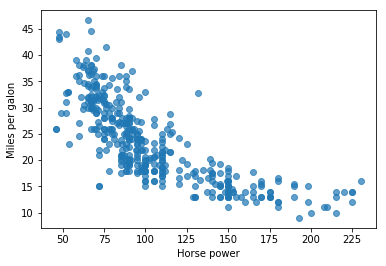

In [17]:
# Define o scatter
plt.scatter(x=bd.horsepower, y=bd.mpg, alpha=.7)
plt.xlabel("Horse power") # Define o label do x
plt.ylabel("Miles per galon") # Define o label do y
plt.show()   # Show!!!

Sabemos também que podemos testar vários graus de polinomiais para ajustar `mpg`. Como podemos descobrir qual é o melhor polinomial? Podemos testar qual dos polinomiais se ajusta melhor usando CV!!!

Vamos testar polinomiais até o grau 5 usando 5-Fold CV:

In [18]:
# fazendo 5 datasets, cada um com número de polinimiais diferentes. O primeiro normal,
# o segundo com X e X**2, o terceiro com X, X**2 e X**3, etc...
X_list = [X]
for i in range(2,11):
    poly = PolynomialFeatures(i)
    new = poly.fit_transform(X)
    X_list.append(new)
len(X_list)

10

In [19]:
# kf10 já foi definido lá em cima
mse_list = []
for i, (train, test) in enumerate(kf10.split(bd)):
    X_train, X_test = X_list[i][train], X_list[i][test]
    y_train, y_test = y[train], y[test]
    reg.fit(X_train, y_train)
    yhat = reg.predict(X_test)
    measure = mean_squared_error(y_test, yhat)
    mse_list.append(measure)

mse_array = np.array(mse_list)
print(len(mse_array))
print(mse_array)

10
[28.34783584 16.55513797 19.97659557 21.77511368 13.0039912  10.82331875
 11.87925373 20.40799137 49.81108114 35.85418681]


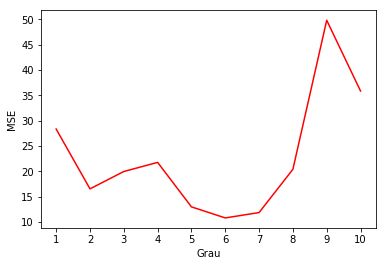

In [20]:
# Plotando um gráfico com os diferentes polinomiais
plt.plot(mse_array, color='red')
plt.xticks(range(10), range(1, 11)) # muda os labels do x para começar no 1
plt.xlabel('Grau')
plt.ylabel('MSE')
plt.show()

## Bootstrap

Agora, vamos experimentar calcular o MSE e o intervalo de confiança da métrica usando bootstrap

In [21]:
# Configurando o bootstrap
n_iterations = 1000  # gera mil amostras
n_size = int(len(X))
print("Sample size: ", n_size)
print("Number of bootstrap iterations: ", n_iterations)

# Executa o bootstrap
stats = []
for i in range(n_iterations):
    X_re, y_re = resample(X, y, replace=True, n_samples=n_size)
    X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size=.3, random_state=2)
    reg.fit(X_train, y_train)
    yhat_boot = reg.predict(X_test)
    measure = mean_squared_error(y_test, yhat_boot)
    stats.append(measure)

stats = np.array(stats)
print("MSE with Bootstrap: ", stats.mean())

Sample size:  392
Number of bootstrap iterations:  1000
MSE with Bootstrap:  24.1099051163842


Vamos agora plotar a distribuição das medidas geradas por bootstrap e calcular o intervalo de confiança a 95%. Espera-se que as medidas possuam uma distribuição normal.

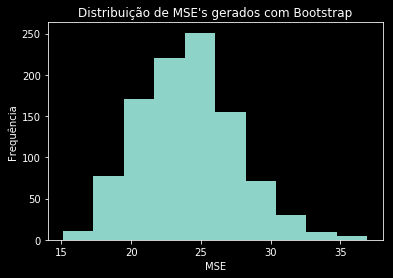

In [22]:
plt.style.use("dark_background")
plt.hist(stats)
plt.title("Distribuição de MSE's gerados com Bootstrap")
plt.xlabel("MSE")
plt.ylabel("Frequência")
plt.show()

Agora, vamos calcular o erro padrão do MSE calculado e o intervalo de confiança.

In [23]:
# Importa funções relacionadas à distribuição t
from scipy.stats import t

In [24]:
print("Teste...")
print("Valor crítico de t a 95% de confiança com 10 gl: ",t.interval(0.95, 10)[1])

# Função para calcular o erro padrão
def stderr(x):
    n = len(x)
    return np.std(x) / np.sqrt(n)

# Função para calcular o intervalo de confiança
def confint95(x):
    n = len(x)
    err = stderr(x)
    endp = t.interval(0.95, n-1)[1]
    up = np.mean(x) + endp*err
    low = np.mean(x) - endp*err
    return np.array([low, up])

print("Funções definidas.")

Teste...
Valor crítico de t a 95% de confiança com 10 gl:  2.2281388519649385
Funções definidas.


In [25]:
print("Erro padrão da média de MSE: ", stderr(stats))
print("Intervalo de confiança do MSE: ", confint95(stats))

Erro padrão da média de MSE:  0.10770353437537113
Intervalo de confiança do MSE:  [23.89855401 24.32125623]


Podemos também usar *bootstrap* para ter uma estimativa mais segura do erro padrão dos coeficientes de um modelo, por exemplo. Para isso, vamos implementar uma função para calcular a

In [26]:
def sum_squared_error(true, pred):
    errors = sum([true[i] - pred[i] for i in range(len(true))])
    return(errors)


def stderr_coef(true, pred, coefs, X):
    sse = sum_squared_error(true, pred)/ float(X.shape[0] - (X.shape[1] + 1) )
    standard_error = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
    return standard_error

stderr_coef(y_test, yhat_boot, reg.coef_, X_train)

array([[0.0001096]])

In [27]:
# Configurando o bootstrap
n_iterations = 1000  # gera mil amostras
n_size = int(len(X))
print("Sample size: ", n_size)
print("Number of bootstrap iterations: ", n_iterations)

# Executa o bootstrap
stats = []
for i in range(n_iterations):
    X_re, y_re = resample(X, y, replace=True, n_samples=n_size)
    X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size=.3, random_state=2)
    reg.fit(X_train, y_train)
    yhat_boot = reg.predict(X_test)
    measure = stderr_coef(y_test, yhat_boot, reg.coef_, X_train)
    stats.append(measure)

stats = np.array(stats)
print("Number of missing data: ", len(stats[~np.isnan(stats)]))
print("Coefs' Std Error with Bootstrap: ", np.nanmean(stats))

Sample size:  392
Number of bootstrap iterations:  1000


/Users/neylson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


Number of missing data:  494
Coefs' Std Error with Bootstrap:  0.00021693973320255068
